### GAN 和 Recurrent GAN 的结构

#### GAN:

![title](./GAN.PNG)

#### RGAN:

![title](./RGAN.PNG)

### 利用LSTM产生一组随机的时间序列（Generator）

In [27]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal

In [28]:
# 产生用于输入Generator的噪声, 为0-1均匀分布
# 其大小为 m x n

def get_noise_sampler():
    return lambda m, n: torch.rand(m, n).requires_grad_()

noise_data = get_noise_sampler()

In [29]:
class Generator(nn.Module):
    def __init__(self, min_val, max_val, input_size=5, hidden_size=20, output_size=1, batch_size=10, seq_len=25):
        super().__init__()
        self.input_size = input_size   # nums of input rand numbers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        self.min_val = min_val  # lower bound of stock price
        self.max_val = max_val  # upper bound of stock price
        self.gap = self.max_val - self.min_val
        
        # 使用单层LSTMCell
        self.layer = nn.LSTMCell(input_size=self.input_size, hidden_size=self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self):
        outputs = []
        
        # LSTM cell的三个输入：input(batch,input_size), h_0(batch,hidden_size), c_0(batch,hidden_size)
        
        # init hidden states and cell state for lstm layer
        h_t = torch.zeros(self.batch_size, self.hidden_size)
        c_t = torch.zeros(self.batch_size, self.hidden_size)
        
        for i in range(self.seq_len):
            # 每个input_t是 batch_size x input_size 的 random tensor
            input_t = noise_data(self.batch_size, self.input_size)
            
            h_t, c_t = self.layer(input_t, (h_t, c_t))
            
            # output的大小为 batch_size x 1
            output = self.linear(h_t)
            
            # 将output放大到 [min_val, max_val] 区间
            output = output.mul(self.gap)
            output = output.add(self.min_val)
            
            outputs += [output]

        # outputs的大小为 batch_size x seq_len
        outputs = torch.stack(outputs, 1).squeeze(2)
        
        return outputs

In [30]:
batch_size = 10
seq_len = 25

g = Generator(20, 30, batch_size=batch_size, seq_len=seq_len)

In [31]:
time_series = g.forward()

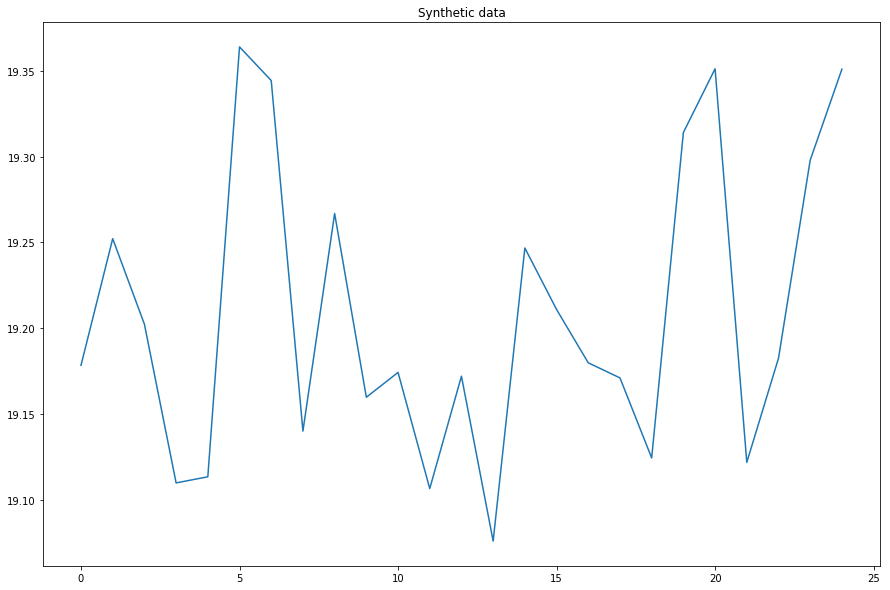

In [32]:
# 画出一条随机的时间序列

x = np.array(range(seq_len))
data = time_series.detach().numpy()

plt.figure("Synthetic data", figsize=(15, 10))
plt.title("Synthetic data")
plt.plot(x, data[9])
plt.show()
plt.close()

### 下面是利用LSTM构造的Discriminator

In [34]:
class Discriminator(nn.Module):
    def __init__(self, input_size=1, hidden_size=20, output_size=1, batch_size=10, seq_len=25):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        # 使用单层LSTMCell
        self.layer = nn.LSTMCell(input_size=self.input_size, hidden_size=self.hidden_size)
        self.linear1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.linear2 = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input_data):
        # input_data的大小为：batch_size x seq_len
        
        outputs = []
        
        # LSTM cell的三个输入：input(batch,input_size), h_0(batch,hidden_size), c_0(batch,hidden_size)
        
        # init hidden states and cell state for lstm layer
        h_t = torch.zeros(self.batch_size, self.hidden_size)
        c_t = torch.zeros(self.batch_size, self.hidden_size)
        
        for input_t in input_data.chunk(input_data.size(1), dim=1):
            # 每个input_t是 batch_size x input_size(1)
            
            h_t, c_t = self.layer(input_t, (h_t, c_t))
            
            # output的大小为 batch_size x 1
            output = self.linear1(h_t)
            output = self.linear2(output)
            output = torch.sigmoid(output)
            outputs += [output]

        # outputs的大小为 batch_size x seq_len
        outputs = torch.stack(outputs, 1).squeeze(2)
        
        return outputs

In [35]:
# 一起测试Generator和Discriminator

# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

batch_size = 5
seq_len = 25

min_val = 30
max_val = 50

g = Generator(min_val, max_val, batch_size=batch_size, seq_len=seq_len)
time_series = g.forward()

d = Discriminator(batch_size=batch_size, seq_len=seq_len)
outputs = d.forward(time_series)

### 构建GAN